In [1]:
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sbi.inference import SNPE,SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
# import ultranest
from sbi.inference import SNPE_C, SNLE_A, SNRE_B
import matplotlib.pyplot as plt
from corner import corner
from tqdm import trange
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
plt.rc('font', size=14)
from scipy.spatial import Voronoi, ConvexHull
from time import time

In [1043]:
ynorm=True
output_dir = '../WASP-39b/multexbi_H2O_nirspec_100atoms_pat20/'
input_file=output_dir+'/input_arcis.dat'

In [1044]:
inp = []
with open(input_file, 'rb') as arcis_input:
    for lines in arcis_input:
        inp.append(str(lines).replace('\\n','').replace("b'","").replace("'", ""))
clean_in = []
for i in range(len(inp)):
    if inp[i]!='' and inp[i][0]!='*':
        clean_in.append(inp[i])
        
freeT=False
    
parnames=[]
prior_bounds=[]
i=0
while i<len(clean_in):
    if 'fitpar:keyword' in clean_in[i]:
        if clean_in[i][16:-1] == 'tprofile':
            freeT=True
            nTpoints = int(clean_in[i+1][9:])
            for j in range(nTpoints):
                parnames.append('dTpoint00'+str(1+j))
                prior_bounds.append([-4/7, 4/7])
#            for k in range(nTpoints):
#                parnames.append('Ppoint00'+str(1+k))
            parnames.append('x')
            prior_bounds.append([0,1])
            i+=3
        else:
            parnames.append(clean_in[i][16:-1])
            if clean_in[i+3]=='fitpar:log=.true.':
                prior_bounds.append([np.log10(float(clean_in[i+1][11:].replace('d','e'))), np.log10(float(clean_in[i+2][11:].replace('d','e')))])
            elif clean_in[i+3]=='fitpar:log=.false.':
                prior_bounds.append([float(clean_in[i+1][11:].replace('d','e')), float(clean_in[i+2][11:].replace('d','e'))])
            i+=4
    else:
        i+=1

prior_bounds=np.array(prior_bounds)
        
### READ OBSERVATIONS
obs=[]
i=0
obsn=1
while i<len(clean_in):
    if 'obs'+str(obsn)+':file' in clean_in[i]:
        obs.append(clean_in[i][len('obs'+str(obsn)+':file')+2:-1])
        obsn+=1
    i+=1

### 1. Load observation/s
# print('Loading observations... ')
# nwvl = np.zeros(len(obs))
nwvl=[0]
for i in range(len(obs)):
    nwvl.append(len(np.loadtxt(obs[i])[:,0]))
l=[0]
obs_spec = np.zeros(int(sum(nwvl)))
noise_spec =np.zeros(int(sum(nwvl)))
for j in range(len(obs)):
    phasej = np.loadtxt(obs[j])
    l.append(len(phasej))
    obs_spec[sum(l[:j+1]):sum(l[:j+2])] = phasej[:,1]
    noise_spec[sum(l[:j+1]):sum(l[:j+2])] = phasej[:,2]

# embedding_net = SummaryNet(obs_spec.shape[0], args.embed_size)

### TRANSFORM PRIOR
class Normalizer():
    def __init__(self, prior_bounds):
        self.bounds = prior_bounds
        
    def transform(self, Y):
        assert len(prior_bounds) == Y.shape[1], 'Dimensionality of prior and parameters doesn\'t match!'
        Yt = np.empty(Y.shape)
        for i in range(Y.shape[1]):
            Yt[:,i] = 2*(Y[:,i] - self.bounds[i][0])/(self.bounds[i][1] - self.bounds[i][0])-1
        return Yt
    
    def inverse_transform(self, Y):
        assert len(prior_bounds) == Y.shape[1], 'Dimensionality of prior and parameters doesn\'t match!'
        Yi = np.empty(Y.shape)
        for i in range(Y.shape[1]):
            Yi[:,i] = (Y[:,i]+1)*(self.bounds[i][1] - self.bounds[i][0])/2 + self.bounds[i][0]
        return Yi
    
prior_bounds = prior_bounds    
if ynorm:
    yscaler = Normalizer(prior_bounds)
#     with open(output_dir+'/yscaler.p', 'wb') as file_yscaler:
#         pickle.dump(yscaler, file_yscaler)

    prior_min = torch.tensor(yscaler.transform(prior_bounds[:,0].reshape(1, -1)).reshape(-1))
    prior_max = torch.tensor(yscaler.transform(prior_bounds[:,1].reshape(1, -1)).reshape(-1))
else:
    prior_min = torch.tensor(prior_bounds[:,0].reshape(1,-1))
    prior_max = torch.tensor(prior_bounds[:,1].reshape(1,-1))
    
prior = utils.BoxUniform(low=prior_min, high=prior_max)

In [1045]:
class SummaryNet(nn.Module):

    def __init__(self, size_in, size_out):
        super().__init__()
        inter = int((size_in+size_out)/2)
        self.fc1 = nn.Linear(size_in, inter)
        self.fc2 = nn.Linear(inter, size_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Corner plot

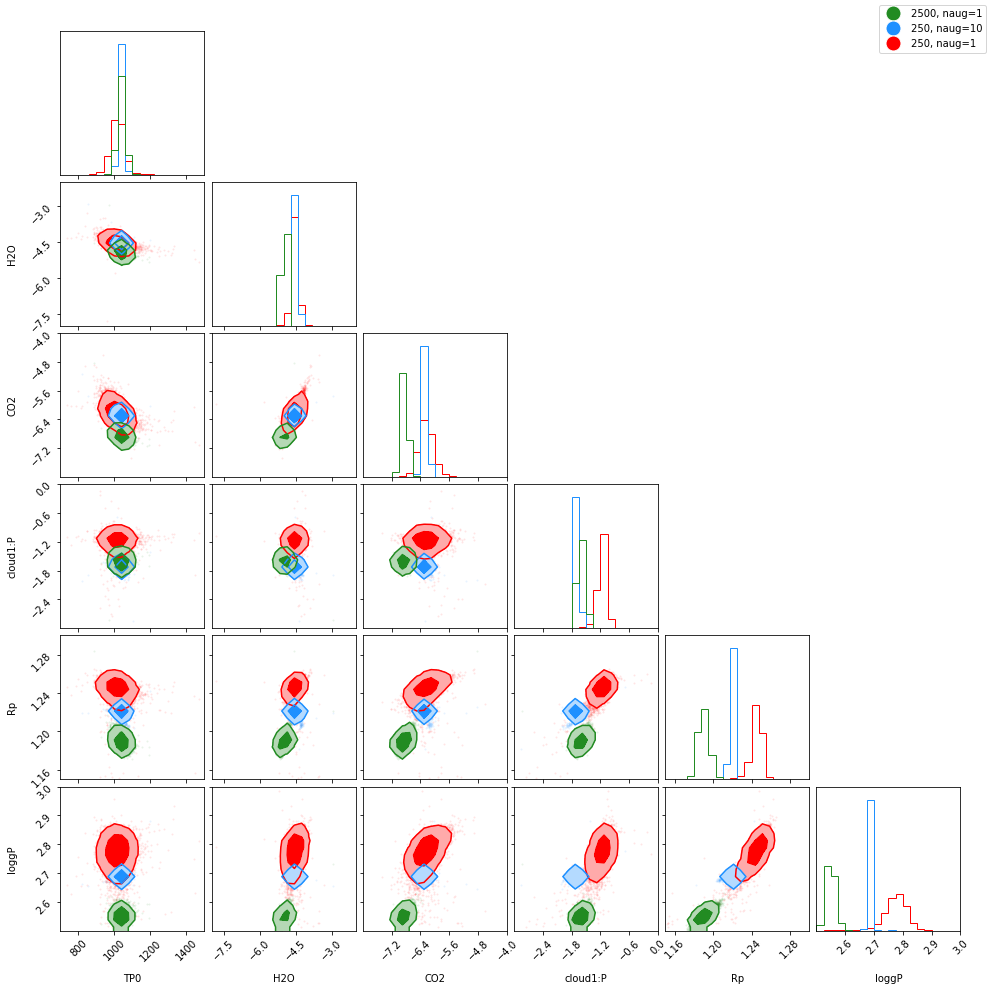

In [999]:
CORNER_KWARGS = dict(
    smooth = .5,
    levels = [0.68, 0.95],
#     quantiles = [0.16, 0.5, 0.84],
#     plot_contours=False,
    fill_contours=True,
#     plot_density=False,
#     show_titles = True,
    labels = parnames,
#     range=prior_bounds,
#     truth=[1042, -4.44, ],
    range = [(700,1500), (-8,-2),(-8,-4),(-3, 0), (1.15,1.3),(2.5,3)],
)

post0 = np.loadtxt(output_dir+'/post_equal_weights.txt')
# post0 = np.loadtxt('../MN_H2O_niriss2.dat')[:,:-1]
# post1 = np.loadtxt('../MN_H2O_niriss1.dat')[:,:-1]
# post2 = np.loadtxt('../MN_H2O_nirspec.dat')[:,:-1]
post1 = np.loadtxt('../WASP-39b/multexbi_H2O_CO2_nirspec_250_naug10/post_equal_weights.txt')
post2 = np.loadtxt('../WASP-39b/multexbi_H2O_CO2_nirspec_2500_naug1/post_equal_weights.txt')
# post0 = np.loadtxt('../WASP-39b/multexbi_H2O_niriss2//post_equal_weights.txt')
# post1 = np.loadtxt('../MN_H2O.dat')[:,:-1]
# post1 = np.loadtxt('../WASP-39b/Multinest/WASP-39b/MN_H2O_CO2_joint/post_equal_weights.dat')[:,:-1]
# post1 = np.loadtxt(output_dir+'_1/post_equal_weights.txt')
# post2 = np.loadtxt(output_dir+'_1000/post_equal_weights.txt')
# post3 = np.loadtxt(output_dir+'_3/post_equal_weights.txt')

figure = corner(post0, color = 'red', **CORNER_KWARGS)

weight1 = np.ones(len(post1))*len(post0)/len(post1)

figure1 = corner(post1, fig=figure, weights=weight1,color='dodgerblue', **CORNER_KWARGS)

weight2 = np.ones(len(post2))*len(post2)/len(post0)

figure2 = corner(post2, fig=figure, weights=weight2, color='forestgreen', **CORNER_KWARGS)

# weights = np.ones(len(post3))*len(post3)/len(post0)

# figure3 = corner(post3, fig=figure, color='orange', **CORNER_KWARGS)

from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='forestgreen'),
                Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='dodgerblue'),
                Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='red'),
               ]

figure.legend(custom_lines, [
                             '2500, naug=1', 
                           '250, naug=10',
                            '250, naug=1'
            ])

## Fit to data

In [1000]:
post_fits = np.load(output_dir+'/arcis_spec_round_10.npy')

med = np.median(post_fits, axis=0)
p1s = np.percentile(post_fits, 84, axis=0)
m1s = np.percentile(post_fits, 16, axis=0)
p2s = np.percentile(post_fits, 97.8, axis=0)
m2s = np.percentile(post_fits, 2.2, axis=0)
p3s = np.percentile(post_fits, 99.9, axis=0)
m3s = np.percentile(post_fits, 0.1, axis=0)

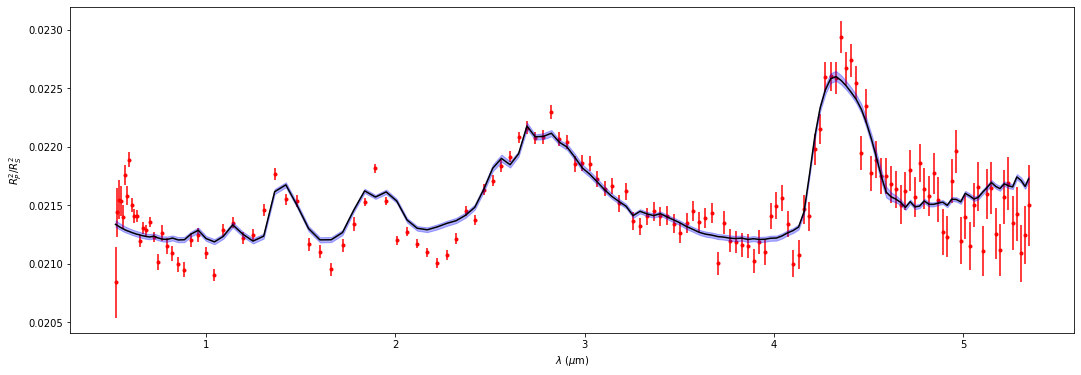

In [1001]:
if len(obs)>1:
    fig,axs = plt.subplots(len(obs), 1, figsize=(18,18))
    for i in range(len(obs)):
        obsi = np.loadtxt(obs[i])
        axs[i].errorbar(x=obsi[:,0], y=obsi[:,1], yerr=obsi[:,2], fmt='.', color='r', zorder=0)
        axs[i].plot(obsi[:,0], med[sum(nwvl[:i+1]):sum(nwvl[:i+1])+nwvl[i+1]],c='k')
        axs[i].fill_between(obsi[:,0], p1s[sum(nwvl[:i+1]):sum(nwvl[:i+1])+nwvl[i+1]],
                                  m1s[sum(nwvl[:i+1]):sum(nwvl[:i+1])+nwvl[i+1]], alpha=0.3, color='b')
        axs[i].set_xlabel(r'$\lambda$ ($\mu$m)')
        axs[i].set_ylabel(r'$R^2_P/R^2_S$')
else:
    fig,axs = plt.subplots(len(obs), 1, figsize=(18,6))
    obsi = np.loadtxt(obs[0])
    axs.errorbar(x=obsi[:,0], y=obsi[:,1], yerr=obsi[:,2], fmt='.', color='r', zorder=0)
    axs.plot(obsi[:,0], med,c='k')
    axs.fill_between(obsi[:,0], p1s,
                              m1s, alpha=0.3, color='b')
    axs.set_xlabel(r'$\lambda$ ($\mu$m)')
    axs.set_ylabel(r'$R^2_P/R^2_S$')

## $\chi_{red}^2$

In [1002]:
def red_chisq(o, m, s, dof):
    return sum((o-m)**2/s**2)/dof

In [1003]:
rchi2 = np.empty(len(post_fits))
for i in trange(len(post_fits)):
    rchi2[i] = red_chisq(obs_spec, post_fits[i], noise_spec, len(obs_spec)-len(prior_bounds))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 16753.63it/s]


In [1004]:
print(np.argmin(rchi2), min(rchi2))

22 5.497135225422262


In [1005]:
if len(obs)>1:
    rchi2=np.empty(len(obs))
    for i in range(len(obs)):
        obsi = np.loadtxt(obs[i])
        post_fitsi = post_fits[np.argmin(rchi2), sum(nwvl[:i+1]):sum(nwvl[:i+1])+nwvl[i+1]]
        rchi2[i] = red_chisq(obsi[:,1], post_fitsi, obsi[:,2], len(obsi[:,1])-len(prior_bounds))

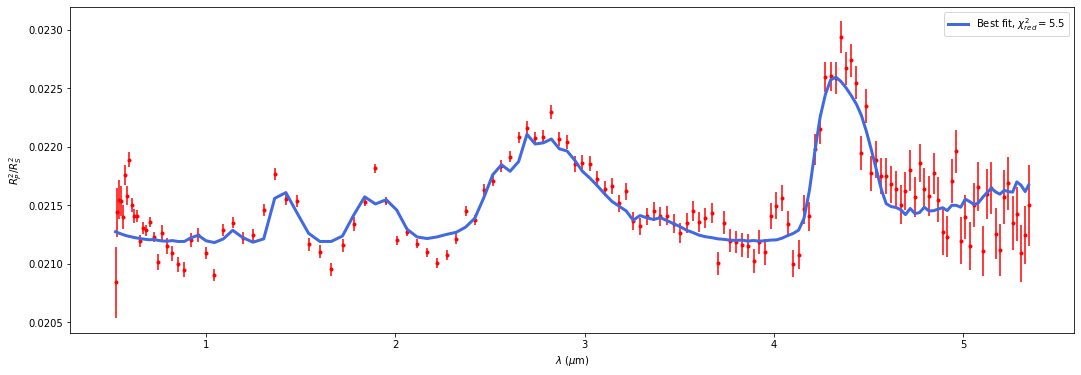

In [1006]:
if len(obs)>1:
    fig,axs = plt.subplots(len(obs), 1, figsize=(18,18))
    for i in range(len(obs)):
        obsi = np.loadtxt(obs[i])
        axs[i].errorbar(x=obsi[:,0], y=obsi[:,1], yerr=obsi[:,2], fmt='.', color='r', zorder=0)
        axs[i].plot(obsi[:,0], post_fits[673][sum(nwvl[:i+1]):sum(nwvl[:i+1])+nwvl[i+1]],c='royalblue', lw=3, label=r'Best fit, $\chi_{red}^2=$'+str(round(rchi2[i], 2)))
        axs[i].set_xlabel(r'$\lambda$ ($\mu$m)')
        axs[i].set_ylabel(r'$R^2_P/R^2_S$')
        axs[i].legend()
else:
    fig,axs = plt.subplots(len(obs), 1, figsize=(18,6))
    obsi = np.loadtxt(obs[0])
    axs.errorbar(x=obsi[:,0], y=obsi[:,1], yerr=obsi[:,2], fmt='.', color='r', zorder=0)
    axs.plot(obsi[:,0], post_fits[np.argmin(rchi2)],c='royalblue', lw=3, label=r'Best fit, $\chi_{red}^2=$'+str(round(min(rchi2), 2)))
    axs.set_xlabel(r'$\lambda$ ($\mu$m)')
    axs.set_ylabel(r'$R^2_P/R^2_S$')
    plt.legend()

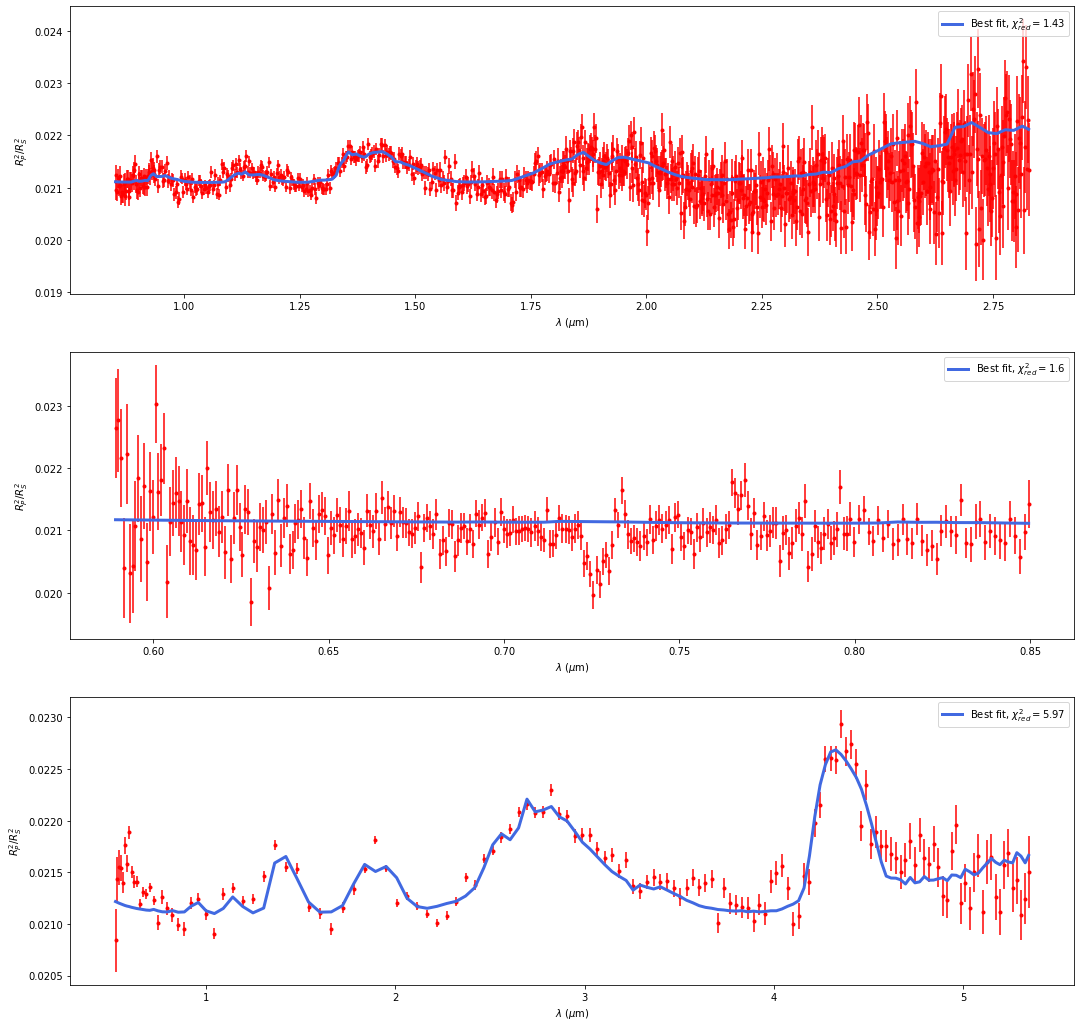

In [955]:
## ONLY FOR MULTINEST

best_fit={}
obsi={}
rchi2={}
for i in range(len(obs)):
    best_fit[i] = np.loadtxt('../WASP-39b/Multinest/WASP-39b/MN_H2O_CO2_joint/obs00'+str(i+1))
    obsi[i] = np.loadtxt(obs[i])
    rchi2[i] = red_chisq(obsi[i][:,1], best_fit[i][:,1], obsi[i][:,2], len(obsi[i][:,1])-len(prior_bounds))

fig,axs = plt.subplots(len(obs), 1, figsize=(18,6*len(obs)))
if len(obs)>1:
    for i in range(len(obs)):
        axs[i].errorbar(x=obsi[i][:,0], y=obsi[i][:,1], yerr=obsi[i][:,2], fmt='.', color='r', zorder=0)
        axs[i].plot(obsi[i][:,0], best_fit[i][:,1],c='royalblue', lw=3, label=r'Best fit, $\chi_{red}^2=$'+str(round(rchi2[i], 2)))
        axs[i].set_xlabel(r'$\lambda$ ($\mu$m)')
        axs[i].set_ylabel(r'$R^2_P/R^2_S$')
        axs[i].legend()
else:   
    axs.errorbar(x=obsi[i][:,0], y=obsi[i][:,1], yerr=obsi[i][:,2], fmt='.', color='r', zorder=0)
    axs.plot(obsi[i][:,0], best_fit[i][:,1],c='royalblue', lw=3, label=r'Best fit, $\chi_{red}^2=$'+str(round(rchi2[i], 2)))
    axs.set_xlabel(r'$\lambda$ ($\mu$m)')
    axs.set_ylabel(r'$R^2_P/R^2_S$')
    axs.legend()

In [956]:
def obs00n2obs(obs00n, obs):
    noisy = np.copy(obs)
    noisy[:,1] = obs00n[:,1] + obs[:,2]*np.random.randn(len(obs00n[:,1]))
    return noisy

## Evidence

$$\mathcal{P}_i=\frac{\mathcal{L}_i\mathcal{\Pi}_i}{\mathcal{Z}}$$

$$\mathcal{Z}=\frac{\mathcal{L}_i\mathcal{\Pi}_i}{\mathcal{P}_i}$$

$$\log{\mathcal{Z}}=\log{\mathcal{L}_i}+\log{\mathcal{\Pi}_i}-\log{\mathcal{P}_i}$$

In [1046]:
posteriors = torch.load(open(output_dir+'/posteriors.pt', 'rb'))

In [1047]:
def likelihood(obs, err, x):
    L = 0
    for i in range(len(obs)):
        L += -np.log(np.sqrt(2*np.pi)*err[i]) + (-(obs[i]-x[i])**2/(2*err[i]**2))
    
    return L

In [1048]:
logZ = np.empty(len(posteriors))
logZp1 = np.empty(len(posteriors))
logZm1 = np.empty(len(posteriors))

for i in trange(len(posteriors)):
    final = posteriors[i]
    model_evals = np.load(output_dir+'/arcis_spec_round_'+str(i)+'.npy')
    L = np.empty(len(model_evals))
    for j in range(len(model_evals)):
        L[j] = likelihood(obs_spec, noise_spec, model_evals[j])
    samples = torch.tensor(np.load(output_dir+'/Y_round_'+str(i)+'.npy'))
    xscaler = pickle.load(open(output_dir+'/xscaler.p', 'rb'))
    default_x = xscaler.transform(obs_spec.reshape(1,-1))
    P = final.log_prob(samples, x=default_x)
    pi = prior.log_prob(samples)
    logZ[i] = np.median(-(P-pi-L).detach().numpy())
    logZp1[i] = np.percentile(-(P-pi-L).detach().numpy(), 84)
    logZm1[i] = np.percentile(-(P-pi-L).detach().numpy(), 16)

100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]


Text(0.5, 0, 'Training round')

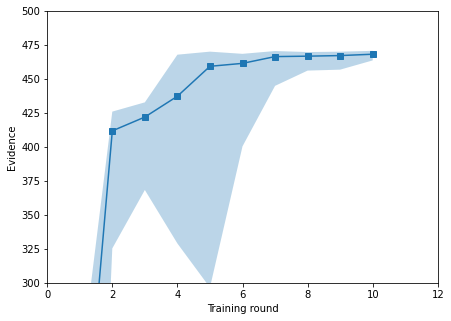

In [1049]:
plt.figure(figsize=(7,5))
plt.plot(range(len(posteriors)), logZ,'s-')
plt.fill_between(range(len(posteriors)), logZm1, logZp1, alpha=0.3)
# plt.axhline(5819.7,c='r')
plt.xlim([0,12])
plt.ylim([300,500])
plt.ylabel('Evidence')
plt.xlabel('Training round')

In [1050]:
logZ

array([-46807.65328442,    135.46369919,    411.79992443,    421.96464087,
          437.29733611,    459.31276906,    461.46960837,    466.45092339,
          466.76675642,    467.20393548,    468.19525164])

In [969]:
final = posteriors[-1]

In [970]:
model_evals = np.load(output_dir+'/arcis_spec_round_10.npy')
# for i in trange(1,len(posteriors)):
#     model_evals=np.concatenate((model_evals, np.load(output_dir+'/arcis_spec_round_'+str(i)+'.npy')))

In [971]:
L = np.empty(len(model_evals))
for i in trange(len(model_evals)):
    L[i] = likelihood(obs_spec, noise_spec, model_evals[i])

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 2264.62it/s]


In [972]:
samples = np.load(output_dir+'/Y_round_10.npy')
# for i in trange(1, len(posteriors)):
#     samples=np.concatenate((samples, np.load(output_dir+'/Y_round_'+str(i)+'.npy')))
samples = torch.tensor(samples)

In [973]:
xscaler = pickle.load(open(output_dir+'/xscaler.p', 'rb'))
default_x = xscaler.transform(obs_spec.reshape(1,-1))

In [974]:
P = final.log_prob(samples, x=default_x)

In [975]:
pi = prior.log_prob(samples)

In [984]:
logZ = (P-pi-L).detach().numpy()
print(-np.median(logZ), -np.percentile(logZ, 16)+np.median(logZ), -np.median(logZ)+np.percentile(logZ, 84))
print(np.mean(-logZ), np.std(-logZ))

827.2234638341886 1.851909721144466 2.1521663182376187
823.1756768711784 34.41617977413481


In [844]:
Z_mn = np.loadtxt('../WASP-39b/Multinest/WASP-39b/MN_H2O_CO2_nirspec/stats.dat')[:,0]

ValueError: could not convert string to float: 'Nested'

In [703]:
print(np.median(Z_mn), -np.percentile(Z_mn, 16)+np.median(Z_mn), -np.median(Z_mn)+np.percentile(Z_mn, 84))
print(np.median(Z_mn), np.percentile(Z_mn, 16), np.percentile(Z_mn, 84))

872.0306877922839 2.0178927282087216 1.195871858822784
872.0306877922839 870.0127950640751 873.2265596511066


In [436]:
sL=np.sort(L[:500])
logz=0
N=len(L[:500])
for i in range(N):
    logz+=sL[i]*np.exp(-i/N)

In [437]:
logz

2212427.022266776

In [438]:
np.mean(final.log_prob(samples).detach().numpy())

12.411578

In [449]:
L

array([  7692.60089191,   7059.27545233,   7515.09403674,   7532.39615429,
         3382.12390821,   7708.48258645,   7767.18025607,   7763.67085978,
         7426.67135968,   7679.71478896,   7451.45806392,   7722.00787958,
         7764.04852999,   7683.45439119,   7452.82371977,   7793.73016193,
         7628.06021628,   7692.78299864,   3238.06253557,   7684.39801171,
         7724.41518149,   7763.59966634,   7766.46638176,   7374.16592185,
         7740.50296867,   7668.6115509 ,   7766.97530099,   7404.66211656,
         7773.5080768 ,   7711.16769466,   7781.23917416,   7724.77042888,
         7775.54358383,   7300.09713314,   7742.43101363,   6999.06693099,
         7492.51015085,   7724.92207871,   7699.11434778,   7744.11238361,
         7432.25249434,   7762.24781041,   7737.14919523,   7758.29582897,
         7673.40029026,   7422.10136115,   7259.17208263,   7723.7807993 ,
         7662.55768674,   7723.9670845 ,   7493.29178475,   7718.22290043,
         7571.61964401,  

In [475]:
sel = (vols!=np.inf)
vols[sel]

array([4.08701408e-03, 1.30187131e-03, 4.39638810e-06, 4.00903341e-06,
       3.01306777e-01, 4.81966893e-05, 2.81038138e-01, 3.35134285e-06,
       1.38985229e-03, 2.02539865e-04, 2.18518527e-04, 1.00980534e-04,
       1.80298987e-07, 1.64341162e-01, 7.28974545e-03, 1.94199684e-03,
       4.61506597e-05, 1.75482871e-03, 2.35152750e-05, 9.63070560e-03,
       1.52794647e-02, 3.56282659e-01, 2.98365843e-02, 2.06593810e-04,
       2.66269796e-06, 2.32508075e-03, 1.94951856e-02, 1.67472689e-04,
       2.09821407e-07, 7.77662996e-06, 3.12389675e-02, 1.01032421e-05,
       1.03227296e+01, 5.71918812e-04, 9.65319375e-05, 6.69431522e-07,
       2.12513161e-06, 6.56955830e-02, 9.11559309e-04, 8.17238830e-07,
       3.85798090e+01, 3.19601527e-05, 1.42228452e-05, 6.61052651e-06,
       2.17912285e-03, 7.73436082e-04, 1.30555599e-03, 4.33950735e+00,
       1.18983170e-05, 2.35122573e-05, 2.84792124e-06, 6.12834458e+00,
       6.22368312e-05, 8.25974997e-04, 2.18069669e-06, 2.11329796e-08,
      

In [477]:
z = 0
for i in range(len(vols[sel])):
    z+=10**int(L[:100][sel][i]-pi[:100][sel][i]-P[:100][sel][i]+np.log10(vols[sel][i]))

In [481]:
np.log10()

OverflowError: int too large to convert to float

## Voronoi Tessellation

In [439]:
def voronoi_volumes(points):
    tic=time()
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    print(time()-tic)
    return vol

In [440]:
inds = P.argsort()

In [447]:
vols = voronoi_volumes(samples[:100])

0.8174030780792236


### From van Haasteren 2018

In [219]:
from scipy.special import gamma, factorial

In [351]:
a=1/100
M = len(samples)
k=int(a*M)

In [352]:
inds = P.argsort()

In [353]:
mu = np.mean(samples[inds][-k:].detach().numpy(), axis=0)

In [354]:
b=1/5
n=int(b*M)

In [355]:
C=0
for i in range(n):
    C +=(samples[inds][-n:][i]-mu).reshape(-1,1)@(samples[inds][-n:][i]-mu).reshape(-1,1).T
C/=n

In [356]:
dist = np.zeros(n)
for i in range(n):
    dist[i] = (samples[inds][-n:][i]-mu).reshape(-1,1).T@C**(-1)@(samples[inds][-n:][i]-mu).reshape(-1,1)

In [357]:
r = np.sqrt(max(dist))

In [358]:
Vt = r**k*np.pi**(k/2)/gamma(1+k/2)*np.sqrt(np.linalg.det(C))

In [359]:
sumP=0
for i in range(k):
    sumP+=1/final.log_prob(samples[inds][-k:][i])
alpha = Vt/sumP
N=len(samples)
I=k*alpha
print(I)

tensor([9.9454e-05])


In [1051]:
for i in range(10):
    print(i)
    if i>5:
        print('>5')
        if i==8:
            break

0
1
2
3
4
5
6
>5
7
>5
8
>5


In [1053]:
z=[0,1,2]
print(z[-3])

0
